Visualization
[here](http://setosa.io/ev/principal-component-analysis/)

PCA in python [here](https://plot.ly/ipython-notebooks/principal-component-analysis/)

In [1]:
# %matplotlib notebook
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from matplotlib import rcParams

# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
    header=None, 
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

X = df.iloc[:,0:4].values  # physical values
y = df.iloc[:,4].values    # category

df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


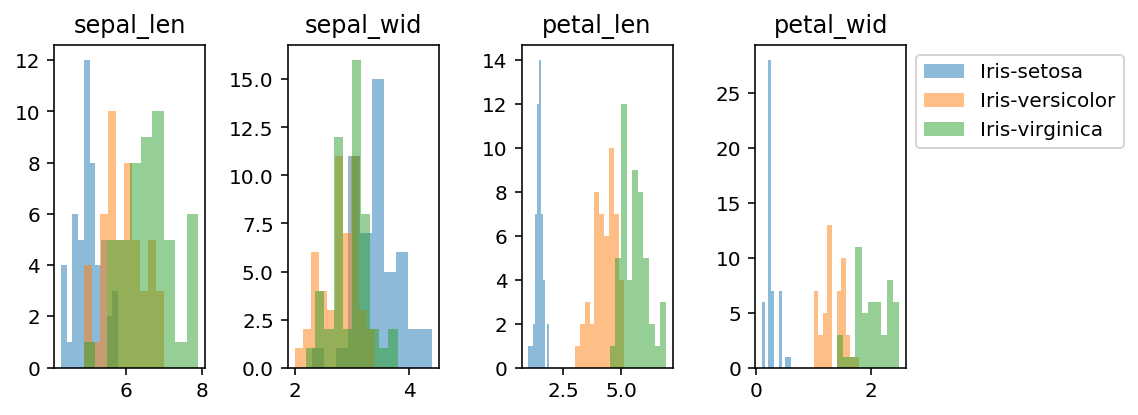

In [3]:
grouped = df.groupby('class')

fig, axs = plt.subplots(1, 4, figsize=(8, 3), sharex=False, sharey=False, gridspec_kw=None)

for i, col in enumerate(df.columns[:-1]):
    for name, g in grouped:
        axs[i].hist(g[col], label=name, alpha=0.5)
    axs[i].set(title=col)
    
axs[-1].legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [4]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

In [5]:
sklearn_pca.components_

array([[ 0.52237162, -0.26335492,  0.58125401,  0.56561105],
       [ 0.37231836,  0.92555649,  0.02109478,  0.06541577]])

In [6]:
sklearn_pca.explained_variance_ratio_

array([0.72770452, 0.23030523])

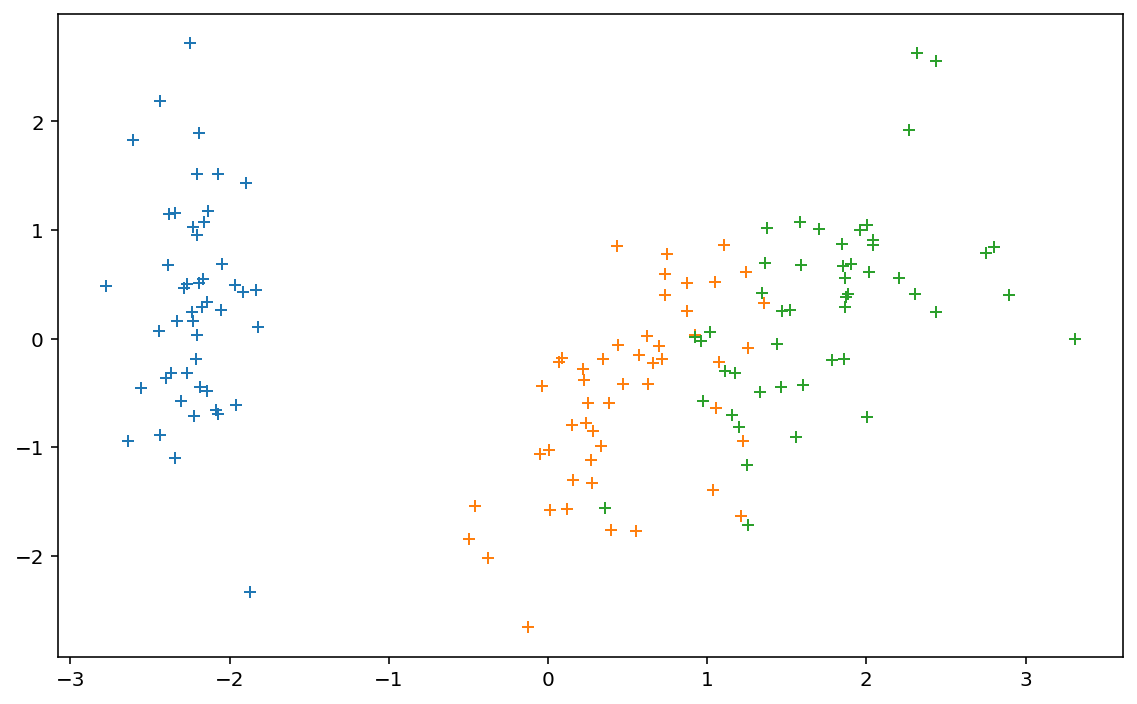

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

for name in np.unique(y):
    axs.plot(Y_sklearn[y==name,0], Y_sklearn[y==name,1], '+')
plt.tight_layout()
plt.show()

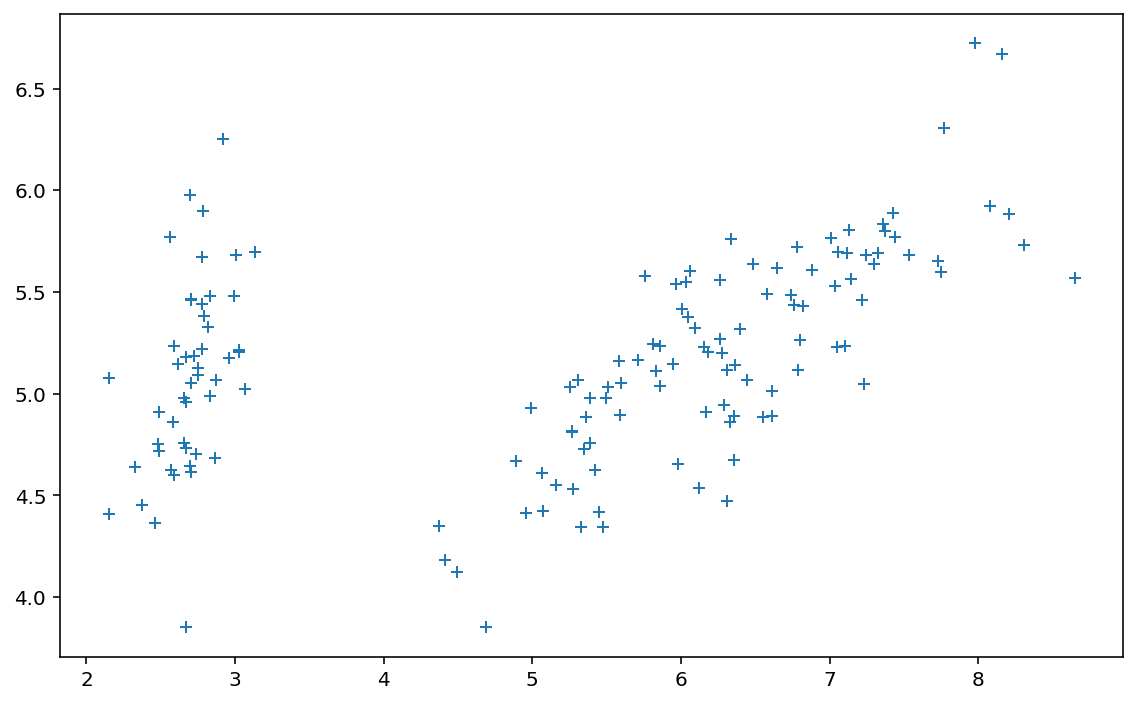

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

plt.plot(np.sum(sklearn_pca.components_[0,:] * X, axis=1), 
         np.sum(sklearn_pca.components_[1,:] * X, axis=1), '+')

plt.tight_layout()
plt.show()

n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.16s	69432	0.602	0.650	0.625	0.465	0.621	0.146
random   	0.15s	69694	0.669	0.710	0.689	0.553	0.686	0.147
PCA-based	0.03s	70804	0.671	0.698	0.684	0.561	0.681	0.118
__________________________________________________________________________________


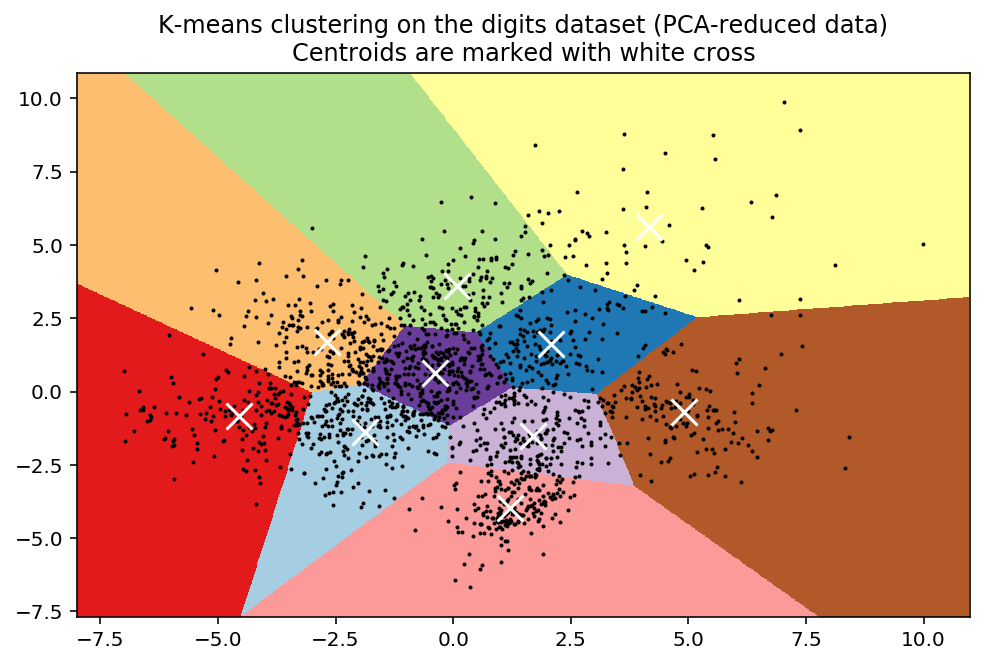

In [9]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_,
                                                average_method='arithmetic'),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

ax.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

ax.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
ax.set(title=('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross'),
       xlim=(x_min, x_max),
       ylim=(y_min, y_max)
      )
# ax.set_xticks(())
# ax.set_yticks(())
plt.show()